In [1]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import os, pickle
from zipfile import ZipFile

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [2]:
window = 50               # Size of array
prediction_horizon = 4    # Maximum prediction horizon
neurons = 64              # Number of neurons in LSTM
n_splits = 10             # Numbers of folds


#**Functions**

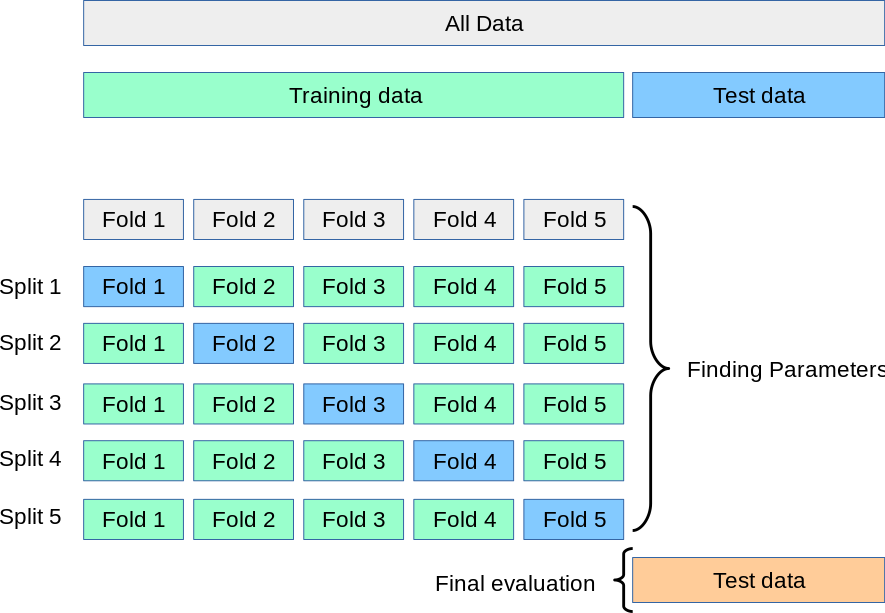

In [3]:
def time_series_cv(X, y, model, n_splits, epochs=10, batch_size=512):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    test_scores = np.zeros((n_splits, 5, y.shape[1]))

    initial_weights = model.get_weights()
    all_fold_weights = {}

    for count, (train_idx, valid_idx) in enumerate(tscv.split(X)):
        print(f"Fold {count + 1}")

        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model.set_weights(initial_weights)
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mae', 'mse'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

        # Forecasting
        y_pred = model.predict(X_test)

        # Guardar los pesos del modelo del fold actual
        all_fold_weights[f'fold_{count + 1}'] = model.get_weights()

        # Resultados
        for i in range(y.shape[1]):
            test_scores[count, 0, i] = round(mean_squared_error(y_test[:, i], y_pred[:, i]), 3)
            test_scores[count, 1, i] = round(mean_squared_error(y_test[:, i], y_pred[:, i], squared=True), 3)
            test_scores[count, 2, i] = round(mean_absolute_error(y_test[:, i], y_pred[:, i]), 3)
            test_scores[count, 3, i] = round(np.mean(np.abs(y_test[:, i] - y_pred[:, i])) * 100, 3)
            test_scores[count, 4, i] = round(r2_score(y_test[:, i], y_pred[:, i]), 3)

    return test_scores, all_fold_weights

#**Load data**

In [4]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

13568290/13568290 [==============================] - 0s 0us/step


In [5]:
# Import data
df = pd.read_csv(csv_path)

# Print dataset
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [7]:
data = df['wv (m/s)']                       # Conjunto de datos a modelar
data = data.fillna(df['wv (m/s)'].mean())    # Remover los valores nan por la media de los datos

data.index = df['Date Time']
data.head()

Date Time
01.01.2009 00:10:00    1.03
01.01.2009 00:20:00    0.72
01.01.2009 00:30:00    0.19
01.01.2009 00:40:00    0.34
01.01.2009 00:50:00    0.32
Name: wv (m/s), dtype: float64

#**Pre-processing**

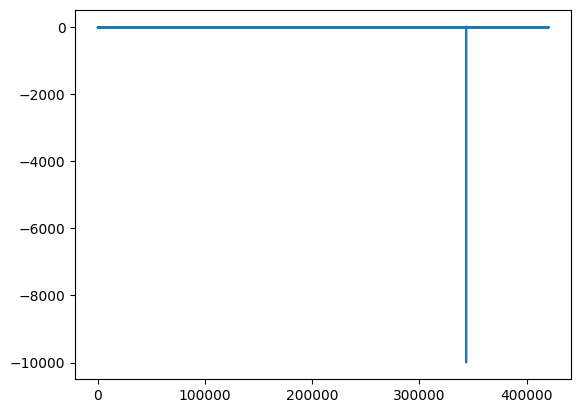

In [8]:
timeSerie = data.values

plt.plot(timeSerie)
plt.show()

In [9]:
meanReplaced = np.mean(timeSerie[0:300000])

meanReplaced

2.150413933333333

In [10]:
result = np.where(timeSerie<0)[0]
result

array([343578, 343579, 343580, 343581, 343582, 343583, 343584, 343585,
       343586, 343587, 343588, 343589, 343590, 343591, 343592, 343593,
       343594, 343595])

In [11]:
for i in result:
  timeSerie[i] = meanReplaced

In [12]:
# Normalización de los datos
timeSerie = data.values
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))

time = np.arange(0, len(timeSerie),1)

In [13]:
X = np.zeros([len(timeSerie)-prediction_horizon-window+1, window])
y = np.zeros([len(timeSerie)-prediction_horizon-window+1, prediction_horizon])

for i in range(X.shape[0]):
  X[i,:] = timeSerie[i:i+window]
  y[i,:] = timeSerie[i+window: i+window+prediction_horizon]

X.shape, y.shape

((420498, 50), (420498, 4))

In [14]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_ = np.reshape(X_, (X_.shape[0], X_.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_.shape, X_test.shape, y_.shape, y_test.shape

((336398, 50, 1), (84100, 50, 1), (336398, 4), (84100, 4))

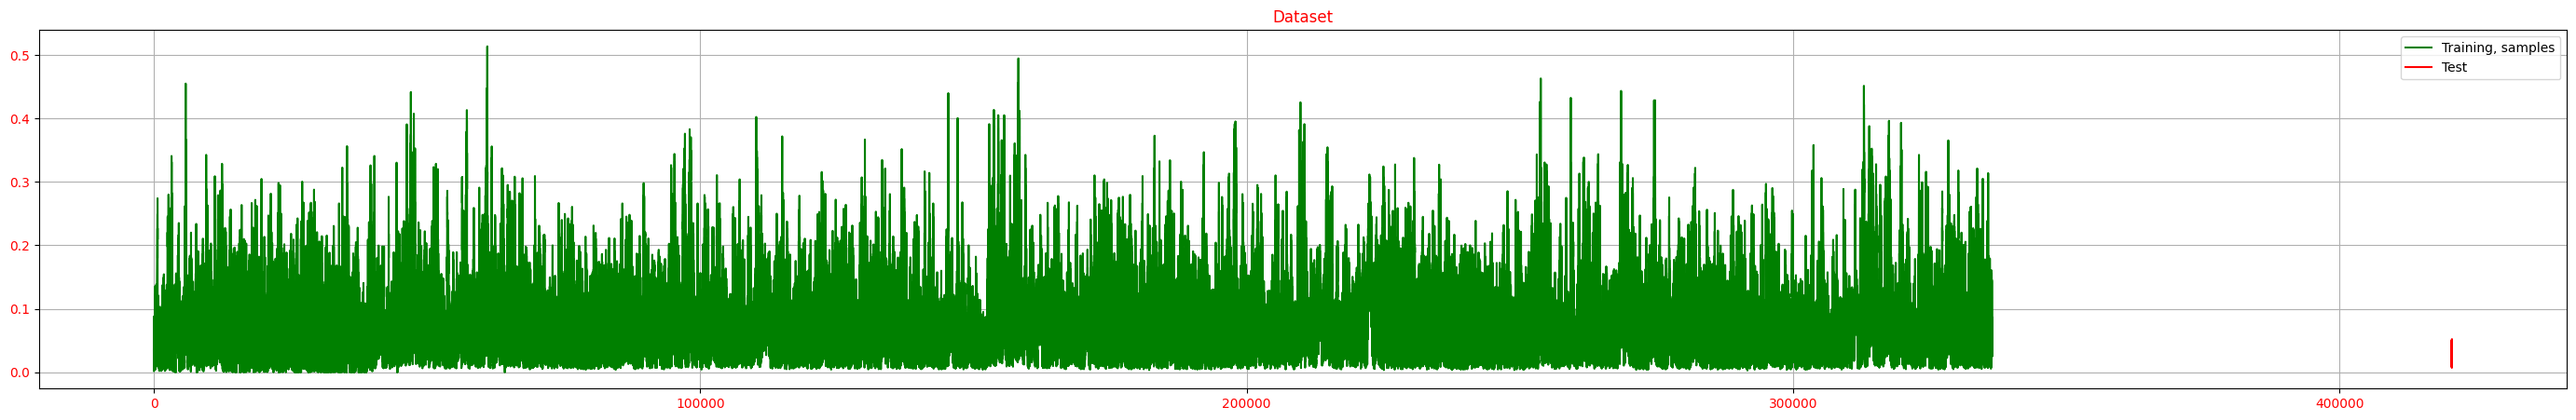

In [15]:
# Ploter el conjunto de datos
plt.figure(figsize=(35,5))
plt.plot(time[0:X_.shape[0]], timeSerie[0:X_.shape[0]], 'g', label= 'Training, samples')
plt.plot(time[X_.shape[0]+X_test.shape[0]:], timeSerie[X_.shape[0]+X_test.shape[0]:], 'r', label= 'Test')
plt.title('Dataset', c='r')
plt.xticks(c='r')
plt.yticks(c='r')
plt.legend()
plt.grid(True)
plt.show()

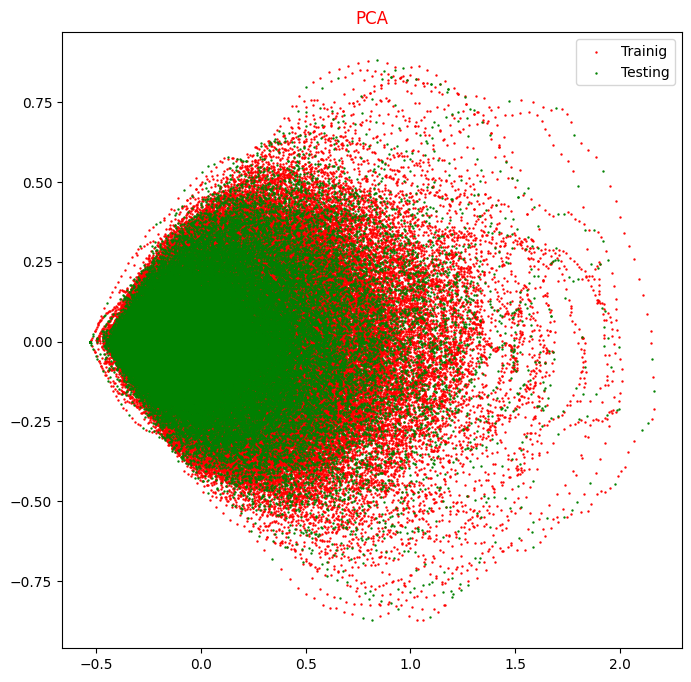

In [16]:
# Analisis exploratorio de los datos
pca = PCA(n_components = 2)
tranformed_pca_train = pca.fit_transform(np.squeeze(X_))
tranformed_pca_test = pca.fit_transform(np.squeeze(X_test))

plt.figure(figsize=(8, 8))
plt.title("PCA", c='r')
plt.scatter(tranformed_pca_train[:,0], tranformed_pca_train[:,1], s=0.5, c='r', label='Trainig')
plt.scatter(tranformed_pca_test[:,0], tranformed_pca_test[:,1], s=0.5, c='g', label='Testing')
plt.legend()
plt.show()

# **Forecasting**

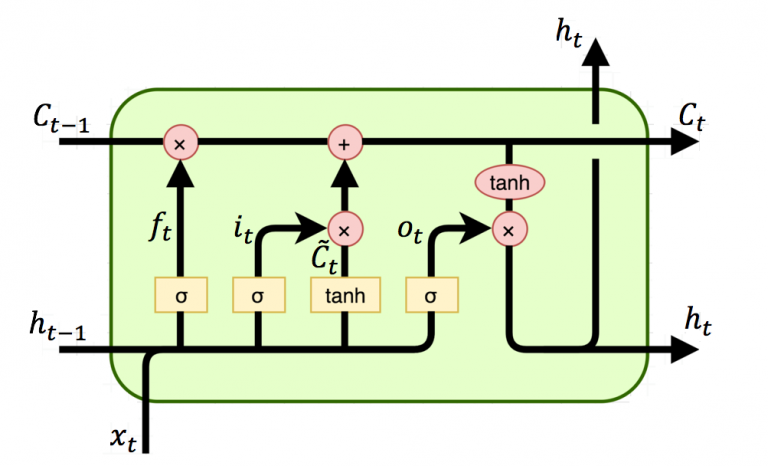

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 1)]           0         
                                                                 
 h1 (LSTM)                   (None, 50, 64)            16896     
                                                                 
 h2 (LSTM)                   (None, 50, 64)            33024     
                                                                 
 h3 (LSTM)                   (None, 50, 64)            33024     
                                                                 
 h4 (LSTM)                   (None, 50, 64)            33024     
                                                                 
 lstm (LSTM)                 (None, 4)                 1104      
                                                                 
Total params: 117072 (457.31 KB)
Trainable params: 117072 (45

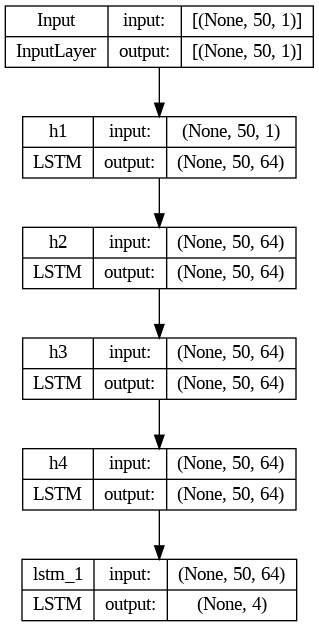

In [17]:
def build_model():

  input = tf.keras.layers.Input(shape=(X_.shape[1], X_.shape[2]), name='Input')
  lstm_1 = tf.keras.layers.LSTM(neurons, activation='relu', return_sequences=True, name='h1')(input)
  lstm_2 = tf.keras.layers.LSTM(neurons, activation='relu', return_sequences=True, name='h2')(lstm_1)
  lstm_3 = tf.keras.layers.LSTM(neurons, activation='relu', return_sequences=True, name='h3')(lstm_2)
  lstm_4 = tf.keras.layers.LSTM(neurons, activation='relu', return_sequences=True, name='h4')(lstm_3)
  output = keras.layers.LSTM(prediction_horizon)(lstm_4)

  model = tf.keras.Model(inputs=input, outputs=output)

  return model

model_LSTM = build_model()

model_LSTM.summary()
keras.utils.plot_model(build_model(), show_shapes=True)

In [18]:
test_scores, all_fold_weights = time_series_cv(X_, y_, model_LSTM, epochs=50, n_splits=n_splits, batch_size=10000)

Fold 1
2629/2629 [==============================] - 91s 34ms/step
Fold 2
2629/2629 [==============================] - 92s 35ms/step
Fold 3
2629/2629 [==============================] - 92s 35ms/step
Fold 4
2629/2629 [==============================] - 92s 35ms/step
Fold 5
2629/2629 [==============================] - 92s 35ms/step
Fold 6
2629/2629 [==============================] - 92s 35ms/step
Fold 7
2629/2629 [==============================] - 92s 35ms/step
Fold 8
2629/2629 [==============================] - 92s 35ms/step
Fold 9
2629/2629 [==============================] - 93s 35ms/step
Fold 10
2629/2629 [==============================] - 92s 35ms/step


#**Results**

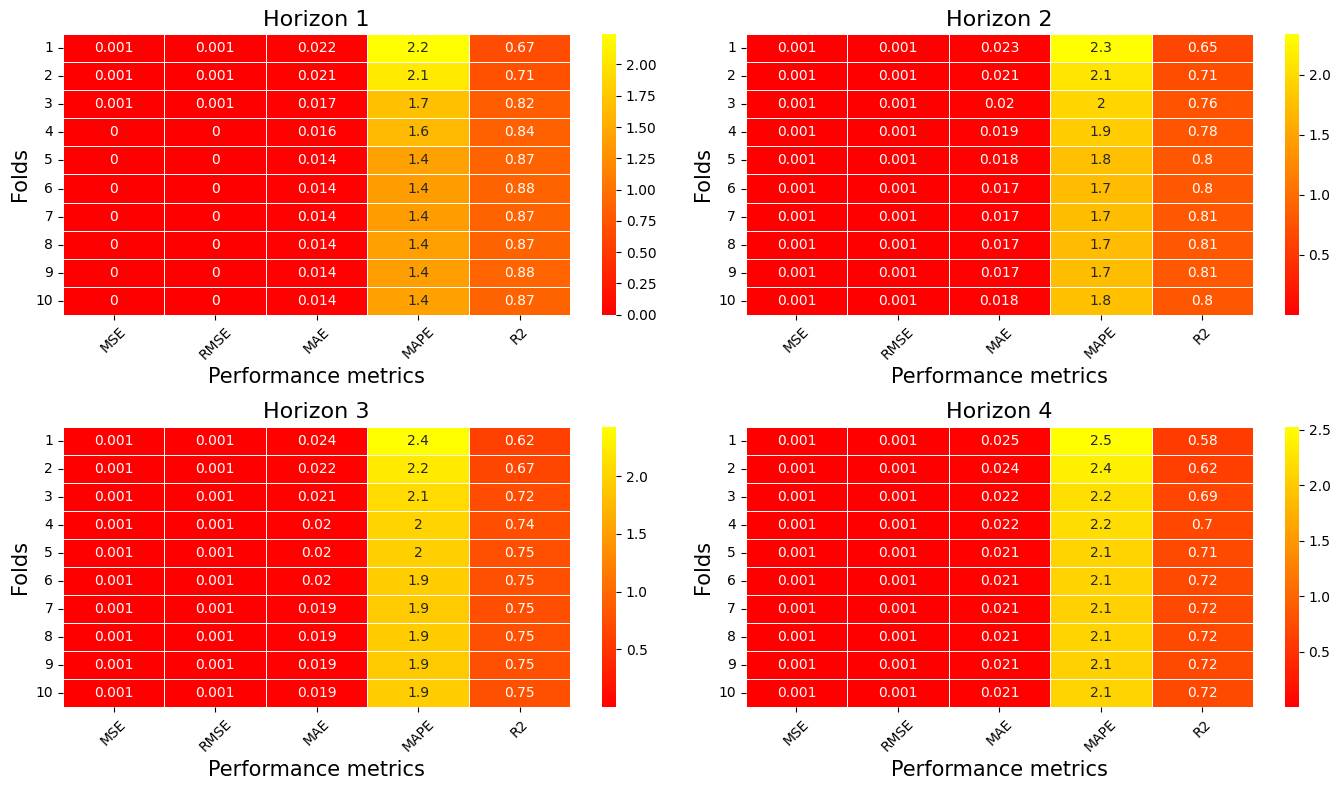

In [19]:
n_splits, n_metrics, n_horizon = test_scores.shape
metric_names = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']

# Calcular el número de columnas necesarias para la disposición de 2 filas
n_cols = int(np.ceil(n_horizon / 2))

plt.figure(figsize=(7 * n_cols, 8))
for i in range(n_horizon):
    plt.subplot(2, n_cols, i + 1)
    ax = sns.heatmap(test_scores[:, :, i], linewidth=0.5, cmap='autumn', annot=True)
    plt.title(f'Horizon {i + 1}', fontsize=16)
    plt.xlabel('Performance metrics', fontsize=15)
    plt.ylabel('Folds', fontsize=15)
    plt.xticks(np.arange(0, 5) + 0.5, metric_names, rotation=45)
    plt.yticks(np.arange(0, n_splits) + 0.5, np.arange(1, n_splits + 1), rotation=0)

plt.tight_layout()
plt.show()

In [29]:
with open(os.getcwd(), 'wb') as f:
  pickle.dump(all_fold_weights, f)
  print(f"All fold weights saved at content")

IsADirectoryError: [Errno 21] Is a directory: '/content'

In [28]:
import os

location = os.getcwd()

location

'/content'